In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm

### Read raw DNA sequences

In [5]:
dataX = pd.read_csv("data/Xtr0.csv", header=None)
dataY = pd.read_csv("data/Ytr0.csv", index_col=0)

In [6]:
#dataX = dataX[0].apply(lambda x: pd.Series(list(x)))

In [7]:
dataY

,Bound
0,1
1,0
2,1
3,1
4,0
5,0
6,1
7,0
8,0
9,0


In [8]:
y = dataY.values

In [9]:
X = dataX.values

### Read numeric embeddings

In [16]:
X = pd.read_csv("data/Xtr0_mat50.csv", sep=' ',header=None).values

In [17]:
X = dataX.values

### Split train test

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.2)

## Kernels

#### for numeric data

In [20]:
def gaussian_kernel_matrix(X, sigma=1):
    return np.exp(- np.sum((X - X[:,None])**2, axis=-1) / (2*sigma**2))

In [21]:
def polynomial_kernel_matrix(X, deg=1):
    return np.sum(X*X[:,None], axis=-1)**deg

#### for raw DNA sequences

In [1]:
def compare_two_seq(s1,s2,a,b):
    res = 0
    n = len(s1)
    assert(n==len(s2))
    for k in range(a,b+1):
        resk = 0
        for i in range(n-k+1):
            if (s1[i:i+k]==s2[i:i+k]):
                resk +=1      
        beta_k = 2*(n-k+1)/(n*(n+1))
        res += resk*beta_k
    return res

def weighted_degree_kernel(X, a, b, name):
    """
    if data/name.npy exists, loads it and returns it, else, compute the WDK of X, comparing sub-strings from
    length a, a+1, a+2 to b, and save it as data/name.npy.
    """
    
    try:
        res = np.load('data/{}.npy'.format(name))
        return res
    except:
        n = len(X)
        K = np.zeros((n,n))
        for i in tqdm(range(n)):
            for j in range(i,n):
                K[i,j] = compare_two_seq(X[i,0], X[j,0],a,b)
                K[j,i] = K[i,j]
        np.save('data/{}'.format(name), K)
        return K

In [11]:
K = weighted_degree_kernel(X,3,4,"a")

  3%|▎         | 68/2000 [00:12<06:03,  5.32it/s]

KeyboardInterrupt: 

In [26]:
np.save('data/weighted_degree_kernel_3kmers', K)

In [169]:
K = np.load('data/weighted_degree_kernel.npy')

In [ ]:
## normalize K (http://qwone.com/~jason/writing/normalizeKernel.pdf)

In [35]:
k = 1/np.sqrt(np.diag(K))

In [44]:
K = K*(np.outer(k,k))

### Kernel ridge regression (KRR)

In [50]:
import scipy
def KRR(K, y, l=0.1):
    A = K + l * len(K)*np.eye(len(K))
    return scipy.linalg.solve(A, y, sym_pos=True)

### SVM (dual formulation)

In [51]:
from scipy.optimize import minimize

class SVM(object):
    
    def __init__(self, K, y, lmbd, x0=None):
        self.K = K
        self.y = y
        self.lmbd = lmbd
        self.yy = np.diag(self.y)
        self.B = np.dot(self.yy,np.dot(self.K,self.yy))
        if x0 is None:
            self.x0 = np.zeros_like(y)
        else:
            self.x0=x0
    def loss(self,mu):
        return -np.sum(mu)+1/(4*self.lmbd)*np.dot(mu.T,np.dot(self.B,mu))

    def loss_der(self,mu):
        return -np.ones_like(mu) + 1/(2*self.lmbd)*np.dot(self.B,mu)

   
    def solve(self):
        
        cons = ({'type':'ineq',
            'fun':lambda mu: -mu,
            'jac':lambda mu: -np.eye(len(mu))},
            {'type':'ineq',
            'fun':lambda mu: mu - np.ones_like(mu)/len(mu),
            'jac':lambda mu: np.eye(len(mu))}
            )
        
        
        res = minimize(self.loss, self.x0, jac=self.loss_der, 
                       constraints=cons, method='SLSQP', options={'disp': True}, tol=1e-4)
        
        
        return np.dot(self.yy,res.x)/(2*self.lmbd)

## little tests

##### fake data

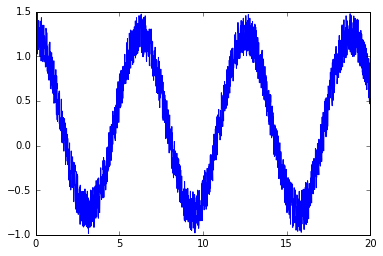

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

def fake_sinus(x, norm = 1):
    data = []
    for i in range(len(x)):
        a = random.random()/norm
        data.append(np.cos(x[i])+a)
    return data

x = np.arange(0,20, 0.01)
plt.plot(x, fake_sinus(x, norm = 2))
plt.show()


In [26]:
data = np.array([[i,fake_sinus([i], norm = 2)[0]] for i in np.arange(0,20, 0.01)])

In [27]:
X = data[:,0]
X = X[:,None]
Y = data[:,1]

In [28]:
X_centered = (X - np.mean(X))/np.std(X)

In [29]:
K = gaussian_kernel_matrix(X)
K_centered = gaussian_kernel_matrix(X_centered)

##### testing KRR

In [30]:
alpha = KRR(K, Y,l=0.001)

In [31]:
y_pred = np.dot(K,alpha)

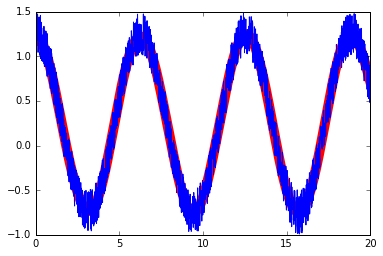

In [38]:
plt.plot(X,y_pred, color='red',lw=10)
plt.plot(X, Y, color="blue")
plt.show()

##### testing SVM

In [ ]:
svm = SVM(K,Y,0.1,x0=np.ones_like(Y)/(2*len(Y)))

In [ ]:
alpha = svm.solve()

In [23]:
y_pred = np.dot(K,alpha)

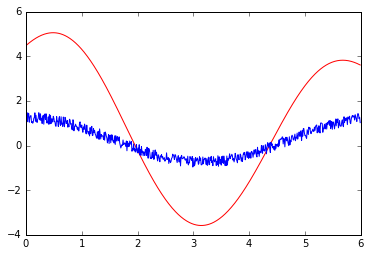

In [24]:
plt.plot(X,y_pred, color='red')
plt.plot(X, Y, color="blue")
plt.show()

### BIG tests

In [52]:
K1 = K[:1600,:1600]
K_test = K[1600:,:1600]
for l in [0.005,0.01,0.1]:
    alpha = KRR(K1, Y_train, l=l)
    y_pred_test = np.dot(K_test,alpha)
    y_pred_train = np.dot(K1,alpha)
    for limit in [0.5]:

        y_pred_final = 1*(y_pred_test > limit)
        print('----')
        print('lambda = {}, limit={}'.format(l,limit))
        print('testing error : ')
        print(np.mean(np.abs(y_pred_final-Y_test)))
        y_pred_final = 1*(y_pred_train > limit)
        print('training error : ')
        print(np.mean(np.abs(y_pred_final-Y_train)))

----
lambda = 0.005, limit=0.5
testing error : 
0.515
training error : 
0.473125
----
lambda = 0.01, limit=0.5
testing error : 
0.515
training error : 
0.49625
----
lambda = 0.1, limit=0.5
testing error : 
0.515
training error : 
0.49625


In [53]:
y

array([[ 1],
       [-1],
       [ 1],
       ..., 
       [ 1],
       [-1],
       [-1]])

In [180]:
y_pred_train

array([[ 0.55256299],
       [ 0.40926747],
       [ 0.45330511],
       ..., 
       [ 0.54678062],
       [ 0.38023847],
       [ 0.38376769]])

In [181]:
y_pred_test

array([[ 0.45656274],
       [ 0.51914205],
       [ 0.4511536 ],
       [ 0.41052458],
       [ 0.43074353],
       [ 0.48637569],
       [ 0.50182409],
       [ 0.47030682],
       [ 0.430444  ],
       [ 0.45005456],
       [ 0.47660284],
       [ 0.40533577],
       [ 0.43023584],
       [ 0.42243671],
       [ 0.46825672],
       [ 0.55859223],
       [ 0.43019143],
       [ 0.45850171],
       [ 0.45282859],
       [ 0.4292482 ],
       [ 0.45734193],
       [ 0.49894569],
       [ 0.46610084],
       [ 0.4596879 ],
       [ 0.53982245],
       [ 0.48152391],
       [ 0.41286927],
       [ 0.4908904 ],
       [ 0.38549884],
       [ 0.42115314],
       [ 0.48399888],
       [ 0.45027981],
       [ 0.44617791],
       [ 0.46605967],
       [ 0.44282732],
       [ 0.49322568],
       [ 0.3993482 ],
       [ 0.42745198],
       [ 0.43436428],
       [ 0.41864872],
       [ 0.49044734],
       [ 0.41761488],
       [ 0.49473816],
       [ 0.49450703],
       [ 0.43839335],
       [ 0

In [3]:
Y

NameError: name 'Y' is not defined